# Task1
## High Level State Representation
- Data is generated by an "expert" player.
- $timeout -sHUP 30m python ./lunar_lander_data_gen.py
    - generates data for 10 minutes
    - saves high level state representation as state_vectors_*.csv
    - saves image files in ./frames/2018-*/frame_2018_*.jpeg
- Train and evaluate a number of supervised machine learning models to predict actions of an "expert" player based off image data.


- Model saved as:
    - ml_states_player.pkl

    Process: CRISP-DM
        Iterating over this workflow
        Assessing data, modeling, evaluating, re-developing
        e.g. Strong accuracies, but poor flight from imbalanced dataset

          -> undersampling

        e.g. Initial learning curves implied immature models

          -> generate more data.



### Reset Colaboratory

In [0]:
!kill -9 -1

### Install Iblearn : non-standard package

In [1]:
! pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
    100% |████████████████████████████████| 153kB 4.7MB/s 


### Upload Local Data:
Uploads were my_lib.py for some useful functions.
And local data file

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print(fn, 'uploaded')
  

Saving my_lib.py to my_lib.py
Saving state_vectors_andy.csv to state_vectors_andy.csv
my_lib.py uploaded
state_vectors_andy.csv uploaded


## Imports

In [0]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import cross_val_score, cross_val_predict, \
                                    GridSearchCV,    train_test_split, \
                                    learning_curve,  StratifiedKFold

from sklearn import metrics
        
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

from imblearn.under_sampling import RandomUnderSampler

from my_lib import topn, plot_learning_curve



### View Project Folder

In [9]:
ls

datalab/  my_lib.py  __pycache__/  state_vectors_andy.csv


### Plug In Data

In [0]:

#Other User
#data_file = "state_vectors_*.csv"

#Andy
data_file = "state_vectors_andy.csv"

#Conor
#data_file = "../state_vectors_2018-04-20-15-12-38.csv"


### Experiment Parameters

In [0]:
#Sample for faster processing
sample_frac = 1

#Stratify to preserve label weightings
grid_search_cv_folds = StratifiedKFold(3, shuffle=True)
cv_experiment_folds = StratifiedKFold(10, shuffle=True)
learning_curve_folds = StratifiedKFold(3, shuffle=True)

### Prepare Dataset
- Undersampled to balance classes.
    - Stabalizer engines are important but infrequent actions.
    - Undersampling helps with model recall/sensitivity.
    - It will be more inclined to use the stablisers appropriately.
- Sampling Dataset to improve processing time.
    - Tune with medium amount of data for find generalizable parameters
  
#### Actions:
        - 0 = no action, 
        - 1=left, 
        - 2=up, 
        - 3=right

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271992 entries, 0 to 76
Data columns (total 8 columns):
pos_x                      271992 non-null float64
pos_y                      271992 non-null float64
vel_x                      271992 non-null float64
vel_y                      271992 non-null float64
ship_lander_angle          271992 non-null float64
ship_lander_angular_vel    271992 non-null float64
leg_1_ground_contact       271992 non-null float64
leg_2_ground_contact       271992 non-null float64
dtypes: float64(8)
memory usage: 28.7 MB


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


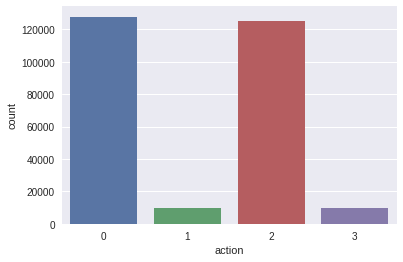

In [12]:
# load dataset for data file
df = pd.read_csv(data_file, header=0, index_col='step')

# split data into X,y (descriptive features, target feature)
X,y = df[[col for col in list(df) if col!='action']], df['action']

#view class label chart
sns.countplot(y)

#show dataframe infromation
pd.DataFrame(X).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37904 entries, 0 to 37903
Data columns (total 8 columns):
0    37904 non-null float64
1    37904 non-null float64
2    37904 non-null float64
3    37904 non-null float64
4    37904 non-null float64
5    37904 non-null float64
6    37904 non-null float64
7    37904 non-null float64
dtypes: float64(8)
memory usage: 2.3 MB


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


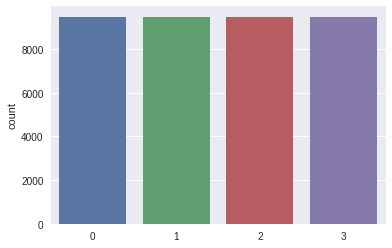

In [13]:
# Apply the random under-sampling
# DataSet is Approx 7 times smaller
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, idx_resample = rus.fit_sample(X,y)
sns.countplot(y_rus)
pd.DataFrame(X_rus).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30323 entries, 0 to 30322
Data columns (total 8 columns):
0    30323 non-null float64
1    30323 non-null float64
2    30323 non-null float64
3    30323 non-null float64
4    30323 non-null float64
5    30323 non-null float64
6    30323 non-null float64
7    30323 non-null float64
dtypes: float64(8)
memory usage: 1.9 MB


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


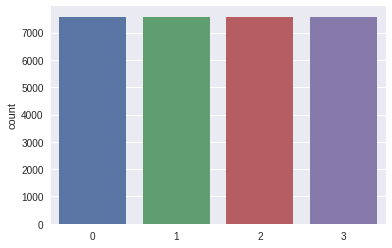

In [14]:
#Take stratified sample for experimenting
n_samples=int(len(y_rus)*sample_frac)
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, 
                                                    train_size=0.80, test_size=20, 
                                                    stratify=y_rus, shuffle=True)
sns.countplot(y_train)
pd.DataFrame(X_train).info()


### Algorithms and Search Space
- RandomForest
    - Forest of Decision Trees each with only subset of features
    - Members tend to be "weaker" but quite diverse.
    - Ensembles non-linear, volatile classifiers
    - Flexible learner for most problems.
    - Relativly quick to train, predict and is compact in memory for most scales of data.
    - Gives good baseline for most problems
    

- Bagging Classifier
    - Forest of Decision Trees each with entire feature set available
    - Members tend to be stronger, but less diverse.
    - Similar benefits to random forest.
    

- MLP
    - Highly non-linear
    - Particularly goog at extracting non linear relationships.
    - Generally long train times.
    - Good baseline for Nueral Nets
    


In [0]:
# list of chosen classifiers.
clfs = [RandomForestClassifier, MLPClassifier, BaggingClassifier]

# dictionary for grid search parameters
param_grids= {
    'RandomForestClassifier': {
        'criterion' : ['gini', 'entropy'],
        'n_estimators' : [5,10,15,20],
        'max_features' : [None, 5, 8]
    },
    'MLPClassifier': {
        'activation' : ['relu',],
        'hidden_layer_sizes' : [(8,8), (16,16), (128,), (256,)],
        'solver' : ['adam'],
        'learning_rate' : ['adaptive', 'constant'],
        'early_stopping' : [True]
    },
    'BaggingClassifier' : {
        'n_estimators' : [5,10,15,20],
        'max_samples' : [0.5,0.75,1],
        'max_features' : [0.5,0.75,1]
    }
}

### Execute Search

In [16]:
%%time
#store the best params and scores for each classifier
stored_grid_searches={}

# running grid search for each classifier
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    current_GS = GridSearchCV(clf(), 
                              param_grids[clf_name],
                              cv=grid_search_cv_folds,
                              verbose=1,
                              n_jobs=-1,
                              return_train_score=True).fit(X_train, y_train)
    
    # store grid search object for each classifier
    stored_grid_searches[clf_name]=current_GS

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.9min finished


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.8min finished


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   34.8s finished


CPU times: user 27.1 s, sys: 10.2 s, total: 37.4 s
Wall time: 4min 41s


### Inspect Search Results

- GridSearch results are double checked
- Models are considered on train/prediction times and accuracy.
- In each case, the best params were judged to be those identified by the grid search.

In [0]:
#store selcted params for each classifier
selected_params={}
    

In [18]:
#print top3 results
RF_GS = stored_grid_searches['RandomForestClassifier']
topn(RF_GS, 10).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
23,7.185,0.041,0.839,0.998,entropy,8,20,"{'criterion': 'entropy', 'max_features': 8, 'n...",1,0.832,0.998,0.842,0.998,0.842,0.998,0.930,0.005,0.005,0.0
15,7.879,0.045,0.838,0.998,entropy,None,20,"{'criterion': 'entropy', 'max_features': None,...",2,0.834,0.998,0.840,0.999,0.839,0.998,0.038,0.001,0.003,0.0
3,3.299,0.047,0.837,0.998,gini,None,20,"{'criterion': 'gini', 'max_features': None, 'n...",3,0.834,0.999,0.837,0.998,0.839,0.998,0.039,0.002,0.002,0.0
19,5.229,0.045,0.835,0.999,entropy,5,20,"{'criterion': 'entropy', 'max_features': 5, 'n...",4,0.828,0.998,0.839,0.999,0.838,0.998,0.051,0.001,0.005,0.0
14,5.862,0.034,0.835,0.997,entropy,None,15,"{'criterion': 'entropy', 'max_features': None,...",5,0.831,0.997,0.839,0.997,0.835,0.996,0.027,0.000,0.003,0.0
11,3.284,0.045,0.834,0.999,gini,8,20,"{'criterion': 'gini', 'max_features': 8, 'n_es...",6,0.833,0.998,0.835,0.999,0.835,0.999,0.062,0.001,0.001,0.0
22,5.876,0.035,0.833,0.996,entropy,8,15,"{'criterion': 'entropy', 'max_features': 8, 'n...",7,0.829,0.996,0.835,0.997,0.835,0.996,0.050,0.000,0.003,0.0
7,2.225,0.047,0.833,0.998,gini,5,20,"{'criterion': 'gini', 'max_features': 5, 'n_es...",8,0.825,0.998,0.836,0.999,0.838,0.998,0.010,0.000,0.006,0.0
2,2.451,0.035,0.833,0.996,gini,None,15,"{'criterion': 'gini', 'max_features': None, 'n...",9,0.831,0.997,0.831,0.996,0.835,0.996,0.006,0.001,0.002,0.0
10,2.472,0.036,0.832,0.997,gini,8,15,"{'criterion': 'gini', 'max_features': 8, 'n_es...",10,0.835,0.997,0.828,0.997,0.833,0.996,0.036,0.001,0.003,0.0


In [19]:
print("best params:", RF_GS.best_params_)
print("best score:", RF_GS.best_score_)

#store best random forest
selected_params['RandomForestClassifier'] = RF_GS.best_params_

best params: {'criterion': 'entropy', 'max_features': 8, 'n_estimators': 20}
best score: 0.8385713814596181


In [20]:
#print top3 results
MLP_GS = stored_grid_searches['MLPClassifier']
topn(MLP_GS, 10).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_activation,param_early_stopping,param_hidden_layer_sizes,param_learning_rate,param_solver,params,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
7,15.487,0.051,0.901,0.901,relu,True,"(256,)",constant,adam,"{'activation': 'relu', 'early_stopping': True,...",...,0.904,0.905,0.898,0.898,0.900,0.901,3.554,0.015,0.002,0.003
6,16.205,0.068,0.885,0.887,relu,True,"(256,)",adaptive,adam,"{'activation': 'relu', 'early_stopping': True,...",...,0.866,0.870,0.884,0.886,0.907,0.906,3.777,0.011,0.017,0.015
4,8.758,0.041,0.875,0.877,relu,True,"(128,)",adaptive,adam,"{'activation': 'relu', 'early_stopping': True,...",...,0.876,0.880,0.884,0.885,0.864,0.867,1.139,0.005,0.008,0.008
2,8.124,0.011,0.868,0.870,relu,True,"(16, 16)",adaptive,adam,"{'activation': 'relu', 'early_stopping': True,...",...,0.882,0.884,0.882,0.885,0.841,0.840,0.911,0.002,0.019,0.021
3,7.595,0.015,0.863,0.865,relu,True,"(16, 16)",constant,adam,"{'activation': 'relu', 'early_stopping': True,...",...,0.845,0.850,0.865,0.865,0.880,0.881,0.582,0.001,0.014,0.013
5,7.750,0.023,0.857,0.858,relu,True,"(128,)",constant,adam,"{'activation': 'relu', 'early_stopping': True,...",...,0.851,0.852,0.830,0.830,0.891,0.891,2.636,0.007,0.025,0.025
1,3.712,0.011,0.799,0.801,relu,True,"(8, 8)",constant,adam,"{'activation': 'relu', 'early_stopping': True,...",...,0.773,0.774,0.833,0.834,0.792,0.794,1.239,0.000,0.025,0.025
0,2.697,0.012,0.796,0.796,relu,True,"(8, 8)",adaptive,adam,"{'activation': 'relu', 'early_stopping': True,...",...,0.798,0.795,0.828,0.833,0.763,0.761,0.756,0.002,0.027,0.030


In [21]:
print("best params:", MLP_GS.best_params_)
print("best score:",  MLP_GS.best_score_)

selected_params['MLPClassifier'] = MLP_GS.best_params_

best params: {'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (256,), 'learning_rate': 'constant', 'solver': 'adam'}
best score: 0.9005705240246678


In [22]:
#print top3 results
BAG_GS = stored_grid_searches['BaggingClassifier']
topn(BAG_GS, 10).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_features,param_max_samples,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
18,1.587,0.040,0.816,0.990,0.75,0.75,15,"{'max_features': 0.75, 'max_samples': 0.75, 'n...",1,0.810,0.989,0.820,0.991,0.817,0.990,0.017,0.001,0.004,0.001
14,1.168,0.038,0.815,0.967,0.75,0.5,15,"{'max_features': 0.75, 'max_samples': 0.5, 'n_...",2,0.821,0.965,0.816,0.969,0.809,0.968,0.011,0.001,0.005,0.002
15,1.536,0.050,0.812,0.972,0.75,0.5,20,"{'max_features': 0.75, 'max_samples': 0.5, 'n_...",3,0.815,0.974,0.810,0.971,0.812,0.972,0.012,0.001,0.002,0.001
19,2.089,0.056,0.807,0.994,0.75,0.75,20,"{'max_features': 0.75, 'max_samples': 0.75, 'n...",4,0.809,0.994,0.795,0.995,0.816,0.993,0.083,0.005,0.009,0.001
17,1.116,0.028,0.806,0.983,0.75,0.75,10,"{'max_features': 0.75, 'max_samples': 0.75, 'n...",5,0.810,0.984,0.800,0.982,0.808,0.984,0.018,0.000,0.004,0.001
13,0.762,0.025,0.802,0.953,0.75,0.5,10,"{'max_features': 0.75, 'max_samples': 0.5, 'n_...",6,0.796,0.949,0.813,0.958,0.797,0.952,0.016,0.000,0.008,0.004
7,1.702,0.060,0.770,0.995,0.5,0.75,20,"{'max_features': 0.5, 'max_samples': 0.75, 'n_...",7,0.778,0.995,0.776,0.994,0.757,0.995,0.055,0.006,0.010,0.001
16,0.533,0.014,0.765,0.955,0.75,0.75,5,"{'max_features': 0.75, 'max_samples': 0.75, 'n...",8,0.789,0.960,0.763,0.956,0.743,0.950,0.006,0.000,0.019,0.004
12,0.389,0.014,0.760,0.916,0.75,0.5,5,"{'max_features': 0.75, 'max_samples': 0.5, 'n_...",9,0.730,0.910,0.769,0.918,0.783,0.920,0.018,0.000,0.022,0.004
6,1.242,0.043,0.748,0.991,0.5,0.75,15,"{'max_features': 0.5, 'max_samples': 0.75, 'n_...",10,0.758,0.992,0.750,0.991,0.736,0.992,0.039,0.001,0.009,0.001


In [23]:
print("best params:", BAG_GS.best_params_)
print("best score:", BAG_GS.best_score_)

selected_params['BaggingClassifier'] = BAG_GS.best_params_

best params: {'max_features': 0.75, 'max_samples': 0.75, 'n_estimators': 15}
best score: 0.8155525508689774


### Selected Params:
Most models fit well, in the case of MLP longer fit times tend to produce better model. The train score and test score tend to be quite close, in contrast to RF and bagging where train scores and validation scores different. MLP gives the best validation score indicating it "generalises" best. This need to be checked with a holdout dataset as turning models extensivly can be a source of "data" leakage for the training set. All models have acceptable train speeds, so even where some models perform slightly weaker, there is no need to optimise for speed where it is in acceptable bounds already. Typical trends can be seen for increasing hidden layer size and ensemble size to improve accuracy.

### 10xCV Experiment : Train Set
Results are reflective or the gridsearch. 10XCV is more robust a measure than 3xCV used in gridsearch. So we can have greater trust in the parameters chosen.

In [24]:
# 10xCV on sample data using selected params
cv_scores = {}
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    params = selected_params[clf_name]
    cv_scores[clf_name] = np.mean(cross_val_score(clf(**params), 
                                                  X_train, y_train,
                                                  cv=cv_experiment_folds,
                                                 n_jobs=-1)) 

# print the avg CVx10 score.
pd.DataFrame(cv_scores, [0]).round(3)

,BaggingClassifier,MLPClassifier,RandomForestClassifier
0,0.821,0.913,0.84


### Learning Curves : Train Set
As indicated by the gridsearch, MLP minimises the gap between training loss and validation loss. RF and Bagging fit strongly to data already seen but tend not to generalise as well. The MLP (which is trained with validation) minimises the delta between training loss and validation loss, giving a model that generalises very well. It can be seen that RF and Bagging look as if they are further in their loss curves, implying diminishing returns in validation accuracy as data increases. They work well on small datasets, but as more data becomes available the MLP surpasses both after about 7500 rus samples.

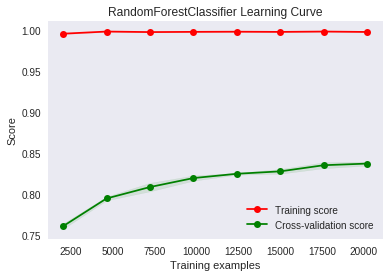

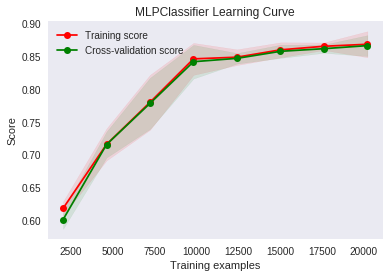

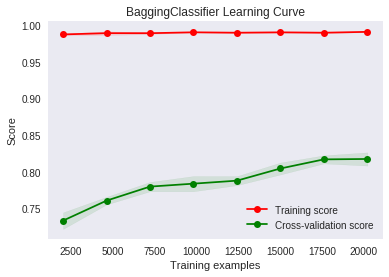

In [25]:
# Print learning curves for each model
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    params = selected_params[clf_name]
    plot_learning_curve(clf(**params), 
                        clf_name+' Learning Curve', 
                        X_train, y_train, 
                        cv=learning_curve_folds,
                        n_jobs=-1)


### Holdout Experiment
Results of holdout experiment confirm support that each model generalises appropriately and data leakage is not a particular concern. Each model generalises well but MLP generalises best.

In [ ]:
#Evaluate with Test dataset
holdout_scores ={}
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    params = selected_params[clf_name]
    model = clf(**params)
    
    #fit model and make predictions
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    #store holdout scores
    holdout_scores[clf_name] = metrics.accuracy_score(y_test, pred)
    
    # Print performance overview
    print(clf_name)
    print('Report:\n',metrics.classification_report(y_test, pred))
    print("Confusion Matrix\n", metrics.confusion_matrix(y_test, pred))

    #Accuracy
    print('Accuracy:',metrics.accuracy_score(y_test, pred))
    print('='*100)

    
    
pd.DataFrame(holdout_scores, [0]).round(3)

RandomForestClassifier
Report:
              precision    recall  f1-score   support

          0       1.00      0.60      0.75         5
          1       0.83      1.00      0.91         5
          2       0.71      1.00      0.83         5
          3       1.00      0.80      0.89         5

avg / total       0.89      0.85      0.85        20

Confusion Matrix
 [[3 1 1 0]
 [0 5 0 0]
 [0 0 5 0]
 [0 0 1 4]]
Accuracy: 0.85
MLPClassifier
Report:
              precision    recall  f1-score   support

          0       1.00      0.80      0.89         5
          1       0.83      1.00      0.91         5
          2       1.00      0.80      0.89         5
          3       0.83      1.00      0.91         5

avg / total       0.92      0.90      0.90        20

Confusion Matrix
 [[4 1 0 0]
 [0 5 0 0]
 [0 0 4 1]
 [0 0 0 5]]
Accuracy: 0.9
BaggingClassifier
Report:
              precision    recall  f1-score   support

          0       1.00      0.60      0.75         5
          1   

,BaggingClassifier,MLPClassifier,RandomForestClassifier
0,0.85,0.9,0.85


### Select Best Learner
The MLP is a clear choice for an ML states player. From testing withing the simulation its capable of scores 200+ indicating its learned expert behaviours solve the lunar lander challenge. It has not yet been observed to score below 200 let alown crash. It could be improved upon with regard to fuel efficiency. The model is accuracte, trains quickly and could likely improve with more generated data. The tradeoff is that the model is limited to this abstract representation of data and the availablity of an "expert" to generate data.

In [27]:
#Pick best model
selected_model = MLPClassifier
model_name = str(selected_model).split(".")[-1][:-2]
params = selected_params[model_name]
model = selected_model(**params)

#train model
model.fit(X_rus, y_rus)

#verify its functioning correctly
model.predict(X_test)

#save model
filename = 'ml_states_player.pkl'
joblib.dump(model, filename)

#load model
model = joblib.load(filename)

#Verify its still working
model.predict(X_test)

#summary
model

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(256,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

### Download File

In [0]:
from google.colab import files

files.download(filename)

In [32]:
!ls

datalab  ml_states_player.pkl  my_lib.py  __pycache__  state_vectors_andy.csv
